In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline

import random
from sklearn.model_selection import train_test_split

In [19]:
df_balanced.to_csv("web_attacks_balanced.csv", index=False)

### Preparing data for training

7 features (Flow ID, Source IP, Source Port, Destination IP, Destination Port, Protocol, Timestamp) are excluded from the dataset. The hypothesis is that the "shape" of the data being transmitted is more important than these attributes. In addition, ports and addresses can be substituted by an attacker, so it is better that the ML algorithm does not take these features into account in training [Kostas2018].

In [20]:
df = pd.read_csv('web_attacks_balanced.csv')
excluded = ['Flow ID', 'Source IP', 'Source Port', 'Destination IP', 'Destination Port', 'Protocol', 'Timestamp']
df = df.drop(columns=excluded)

Below at the stage of importance estimation the "Init_Win_bytes_backward" feature has the maximum value. After viewing the source dataset, it seems that an inaccuracy was made in forming the dataset. 

It turns out that it is possible to make a fairly accurate classification by one feature.

Description of features: http://www.netflowmeter.ca/netflowmeter.html

     Init_Win_bytes_backward - The total number of bytes sent in initial window in the backward direction
     Init_Win_bytes_forward - The total number of bytes sent in initial window in the forward direction

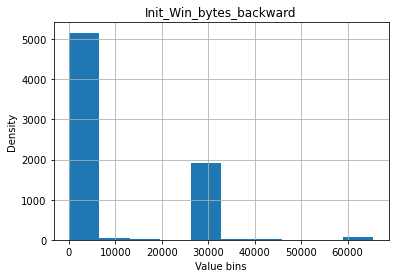

In [21]:
if 'Init_Win_bytes_backward' in df.columns:
    df['Init_Win_bytes_backward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_backward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_backward.png', dpi=300)

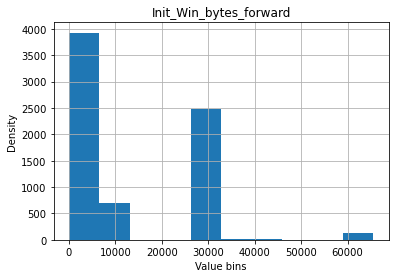

In [22]:
if 'Init_Win_bytes_forward' in df.columns:
    df['Init_Win_bytes_forward'].hist(figsize=(6,4), bins=10);
    plt.title("Init_Win_bytes_forward")
    plt.xlabel("Value bins")
    plt.ylabel("Density")
    plt.savefig('Init_Win_bytes_forward.png', dpi=300)

In [23]:
excluded2 = ['Init_Win_bytes_backward', 'Init_Win_bytes_forward']
df = df.drop(columns=excluded2)

The Label column is encoded as follows: "BENIGN" = 0, attack = 1.

In [24]:
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y = df['Label'].values
X = df.drop(columns=['Label'])
print(X.shape, y.shape)

(7267, 74) (7267,)


## Feature importance

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 3575, 1: 1511}

### Visualization of the decision tree, importance evaluation using a single tree (DecisionTreeClassifier)
 
In the beginning we use one tree - for the convenience of visualization of the classifier. High cross-validation scores even with 5 leaves look suspiciously good, we should look at the data carefully. Parameters for change - test_size in the cell above (train_test_split), max_leaf_nodes in the cell below.
 
By changing the **random_state** parameter, we will get different trees and different features with the highest importance. But the forest will already average individual trees below.

In [26]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier(max_leaf_nodes=5, random_state=0)
decision_tree = decision_tree.fit(X_train, y_train)
cross_val_score(decision_tree, X_train, y_train, cv=10)

array([0.96267191, 0.96463654, 0.96070727, 0.95284872, 0.94499018,
       0.956778  , 0.95866142, 0.95275591, 0.96456693, 0.96259843])

In [27]:
from sklearn.tree import export_text
r = export_text(decision_tree, feature_names=X_train.columns.to_list())
print(r)

|--- Packet Length Mean <= 0.86
|   |--- Fwd IAT Std <= 2453677.25
|   |   |--- Bwd Packets/s <= 8889.06
|   |   |   |--- class: 0
|   |   |--- Bwd Packets/s >  8889.06
|   |   |   |--- class: 0
|   |--- Fwd IAT Std >  2453677.25
|   |   |--- class: 1
|--- Packet Length Mean >  0.86
|   |--- Subflow Fwd Bytes <= 34327.50
|   |   |--- class: 0
|   |--- Subflow Fwd Bytes >  34327.50
|   |   |--- class: 1



Analyze the confusion matrix. Which classes are confidently classified by the model?

In [28]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 1512, 1: 669}

In [29]:
from sklearn.metrics import confusion_matrix
y_pred = decision_tree.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1504,    8],
       [  88,  581]])

### Importance evaluation using SelectFromModel (still one decision tree)

Source: https://github.com/oreilly-mlsec/book-resources/blob/master/chapter2/select-from-model-nslkdd.ipynb

In [30]:
from sklearn.feature_selection import SelectFromModel
sfm = SelectFromModel(estimator=decision_tree).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.19099051, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01898816, 0.        , 0.        , 0.7325242 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.05749714, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ])

In [31]:
sfm.threshold_

0.013513513513513514

In [32]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 74, selected num features: 4


In [33]:
indices = np.argsort(decision_tree.feature_importances_)[::-1]
for idx, i in enumerate(indices[:10]):
    print("{}.\t{} - {}".format(idx, X_train.columns[i], decision_tree.feature_importances_[i]))

0.	Packet Length Mean - 0.7325242036208035
1.	Fwd IAT Std - 0.19099050509307136
2.	Subflow Fwd Bytes - 0.05749713616028083
3.	Bwd Packets/s - 0.018988155125844283
4.	Bwd IAT Std - 0.0
5.	Fwd IAT Mean - 0.0
6.	Fwd IAT Max - 0.0
7.	Fwd IAT Min - 0.0
8.	Bwd IAT Total - 0.0
9.	Bwd IAT Mean - 0.0


### Evaluation of importance using RandomForestClassifier.feature_importances_ (move from one tree to a random forest, classification quality increases)

In [34]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=250, random_state=42, oob_score=True)
rf.fit(X_train, y_train)
# Score = mean accuracy on the given test data and labels
print('R^2 Training Score: {:.2f} \nR^2 Validation Score: {:.2f} \nOut-of-bag Score: {:.2f}'
      .format(rf.score(X_train, y_train), rf.score(X_test, y_test), rf.oob_score_))

R^2 Training Score: 0.99 
R^2 Validation Score: 0.98 
Out-of-bag Score: 0.98


In [35]:
features = X.columns
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

for i in indices[:20]:
    print('#{}\t{:.3f}\t{}'.format(i, importances[i], features[i]))

#13	0.087	Flow Bytes/s
#51	0.086	Average Packet Size
#39	0.061	Packet Length Mean
#38	0.059	Max Packet Length
#7	0.055	Fwd Packet Length Mean
#23	0.053	Fwd IAT Min
#61	0.049	Subflow Fwd Bytes
#52	0.048	Avg Fwd Segment Size
#3	0.042	Total Length of Fwd Packets
#15	0.034	Flow IAT Mean
#21	0.030	Fwd IAT Std
#33	0.029	Fwd Header Length
#5	0.028	Fwd Packet Length Max
#16	0.024	Flow IAT Std
#0	0.023	Flow Duration
#14	0.023	Flow Packets/s
#22	0.021	Fwd IAT Max
#35	0.020	Fwd Packets/s
#19	0.018	Fwd IAT Total
#17	0.017	Flow IAT Max


For comparison, the results of the study [Sharafaldin2018] (compare relatively, without taking into account the multiplier):
 
* Init Win F.Bytes 0.0200
* Subflow F.Bytes 0.0145
* Init Win B.Bytes 0.0129
* Total Len F.Packets 0.0096

And incorrect results [Kostas2018] (error was found in assessing the importance of features, line: *impor_bars = pd.DataFrame({'Features':refclasscol[0:20],'importance':importances[0:20]})*, the importances[0:20] sample does not take into account that the values are not sorted in descending order):
 
* Flow Bytes/s 0.313402
* Total Length of Fwd Packets 0.304917
* Flow Duration 0.000485
* Fwd Packet Length Max 0.00013

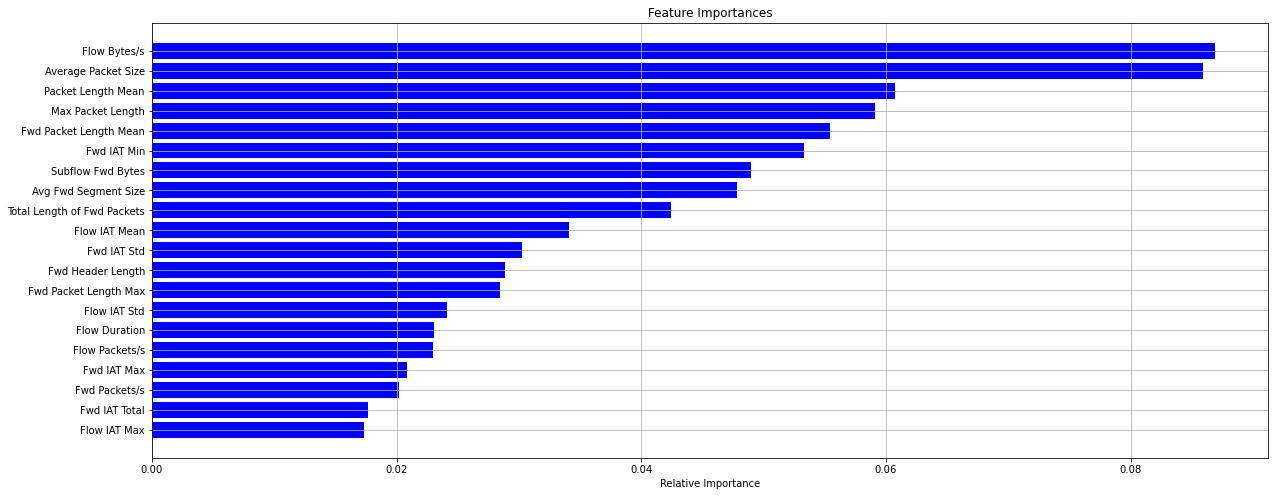

In [36]:
indices = np.argsort(importances)[-20:]
plt.rcParams['figure.figsize'] = (20, 8)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.grid()
plt.savefig('feature_importances.png', dpi=300)
plt.show()

Make sure that SelectFromModel shows the same results.

In [37]:
sfm = SelectFromModel(estimator=rf).fit(X_train, y_train)
sfm.estimator_.feature_importances_

array([2.30389501e-02, 9.55527717e-03, 3.51278692e-03, 4.23959829e-02,
       6.49436307e-03, 2.84865584e-02, 1.58938645e-04, 5.54278766e-02,
       4.72614485e-03, 3.00795152e-03, 2.46639450e-04, 2.15631753e-03,
       1.63168975e-03, 8.68742430e-02, 2.30055271e-02, 3.40793127e-02,
       2.40848491e-02, 1.73717590e-02, 1.33065122e-02, 1.76826901e-02,
       1.63579513e-02, 3.02554689e-02, 2.08701979e-02, 5.33217310e-02,
       4.39680736e-03, 2.83001761e-03, 2.18206449e-03, 2.46353431e-03,
       3.75613088e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 2.88523095e-02, 1.72811951e-02, 2.02120100e-02,
       1.09809813e-02, 2.90142706e-04, 5.90597532e-02, 6.07393524e-02,
       5.14903800e-03, 5.58419809e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 9.64485565e-03, 1.25604426e-02, 3.84288506e-03,
       0.00000000e+00, 0.00000000e+00, 8.80863725e-04, 8.59384500e-02,
       4.78404621e-02, 3.47266236e-03, 0.00000000e+00, 0.00000000e+00,
      

In [38]:
X_train_new = sfm.transform(X_train)
print("Original num features: {}, selected num features: {}"
      .format(X_train.shape[1], X_train_new.shape[1]))

Original num features: 74, selected num features: 22


In [39]:
indices = np.argsort(rf.feature_importances_)[::-1]
webattack_features = []
for idx, i in enumerate(indices):
    webattack_features.append(X_train.columns[i])
    if idx < 20:
        print("{}.\t{} - {}".format(idx, X_train.columns[i], rf.feature_importances_[i]))

0.	Flow Bytes/s - 0.08687424301815491
1.	Average Packet Size - 0.08593844995835177
2.	Packet Length Mean - 0.060739352370688136
3.	Max Packet Length - 0.05905975315149098
4.	Fwd Packet Length Mean - 0.055427876589689715
5.	Fwd IAT Min - 0.05332173103289086
6.	Subflow Fwd Bytes - 0.048992732318333405
7.	Avg Fwd Segment Size - 0.047840462053264574
8.	Total Length of Fwd Packets - 0.04239598286137619
9.	Flow IAT Mean - 0.03407931269519242
10.	Fwd IAT Std - 0.030255468866471444
11.	Fwd Header Length - 0.028852309487894016
12.	Fwd Packet Length Max - 0.02848655836744046
13.	Flow IAT Std - 0.024084849091825095
14.	Flow Duration - 0.02303895007761567
15.	Flow Packets/s - 0.023005527136492315
16.	Fwd IAT Max - 0.020870197907981718
17.	Fwd Packets/s - 0.02021201004619953
18.	Fwd IAT Total - 0.017682690075573687
19.	Flow IAT Max - 0.01737175896611022


Once again we analyze the confusion matrix, now for a higher quality classifier. A random forest also badly distinguishes between separate attack classes ("Web Attack – XSS" is very similar to "Web Attack – Brute Force"). At the same time, the "BENIGN" class is well separated from the others.
 
If we combine different attack classes into one "web attack" class, the resulting binary classifier will show high quality.

In [40]:
y_pred = rf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[1493,   19],
       [  31,  638]])

Next, for experiments, we keep the first max_features of features with maximum importance.

In [41]:
max_features = 20
webattack_features = webattack_features[:max_features]
webattack_features

['Flow Bytes/s',
 'Average Packet Size',
 'Packet Length Mean',
 'Max Packet Length',
 'Fwd Packet Length Mean',
 'Fwd IAT Min',
 'Subflow Fwd Bytes',
 'Avg Fwd Segment Size',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd IAT Std',
 'Fwd Header Length',
 'Fwd Packet Length Max',
 'Flow IAT Std',
 'Flow Duration',
 'Flow Packets/s',
 'Fwd IAT Max',
 'Fwd Packets/s',
 'Fwd IAT Total',
 'Flow IAT Max']

## Analysis of selected features

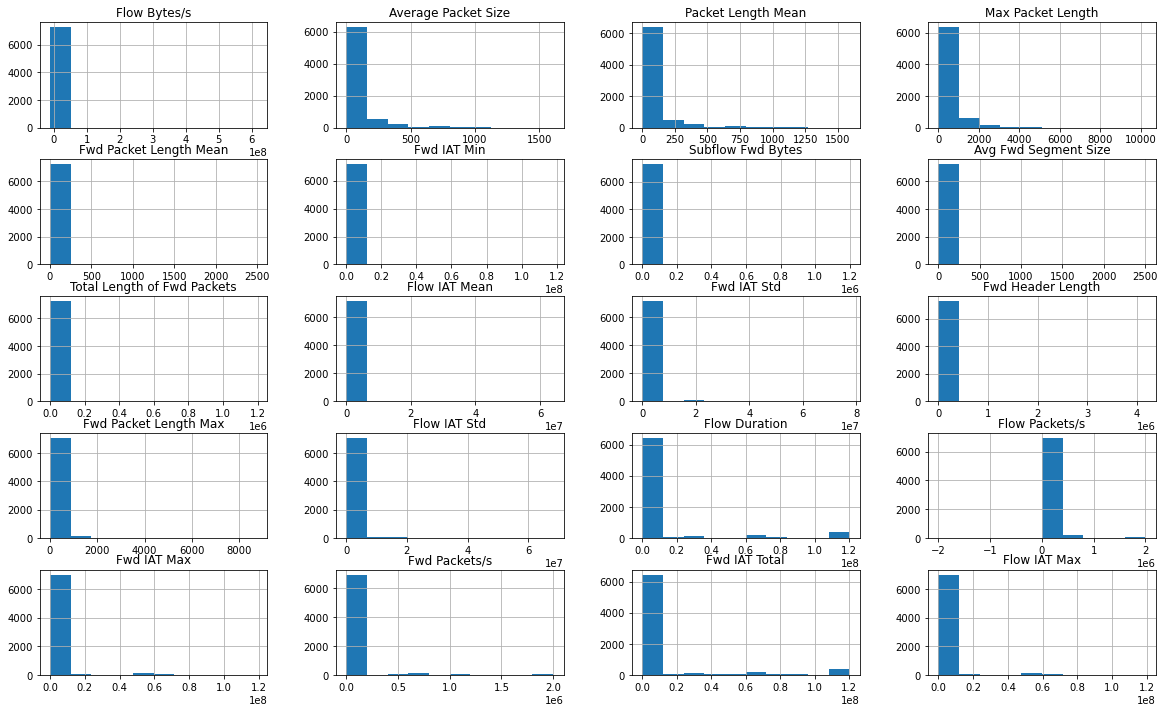

In [42]:
df[webattack_features].hist(figsize=(20,12), bins=10);
plt.savefig('features_hist.png', dpi=300)

Install Facets Overview

https://pair-code.github.io/facets/

Create the feature stats for the datasets and stringify it.

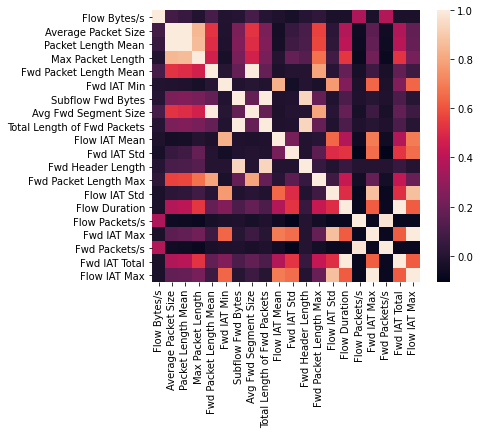

In [43]:
import seaborn as sns
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix);
plt.savefig('corr_heatmap.png', dpi=300)

Remove correlated features.

In [44]:
to_be_removed = {'Packet Length Mean', 'Avg Fwd Segment Size', 'Subflow Fwd Bytes', 'Fwd Packets/s', 'Fwd IAT Total'}
webattack_features = [item for item in webattack_features if item not in to_be_removed]
webattack_features = webattack_features[:10]
webattack_features

['Flow Bytes/s',
 'Average Packet Size',
 'Max Packet Length',
 'Fwd Packet Length Mean',
 'Fwd IAT Min',
 'Total Length of Fwd Packets',
 'Flow IAT Mean',
 'Fwd IAT Std',
 'Fwd Header Length',
 'Fwd Packet Length Max']

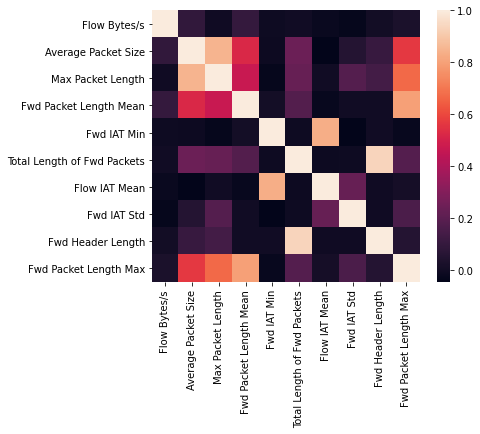

In [45]:
corr_matrix = df[webattack_features].corr()
plt.rcParams['figure.figsize'] = (6, 5)
sns.heatmap(corr_matrix);

## Hyperparameter selection

Reopen the dataset.

In [46]:
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('web_attacks_balanced.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else (0 if random.random() < 0 else 1))
y = df['Label'].values
X = df[webattack_features]
print(X.shape, y.shape)

(7267, 10) (7267,)


We get the list of RandomForestClassifier parameters.

In [47]:
rfc = RandomForestClassifier(random_state=1)
rfc.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

For search of quasi-optimal value of one parameter we fix the others.

In [48]:
parameters = {'n_estimators': [10],
              'min_samples_leaf': [3],
              'max_features': [3], 
              'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 15, 20, 30, 50]}
scoring = {'f1', 'accuracy'}
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')
results = gcv.cv_results_

CPU times: user 6.98 s, sys: 39.8 ms, total: 7.02 s
Wall time: 7.03 s


In [49]:
cv_results = pd.DataFrame(gcv.cv_results_)
cv_results.head(1)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_n_estimators,params,split0_test_f1,...,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,mean_train_accuracy,std_train_accuracy
0,0.025241,0.001252,0.003677,0.000858,1,3,3,10,"{'max_depth': 1, 'max_features': 3, 'min_sampl...",0.891509,...,0.907951,0.90474,0.906575,0.907798,0.904587,0.904449,0.90506,0.907201,0.905876,0.001788


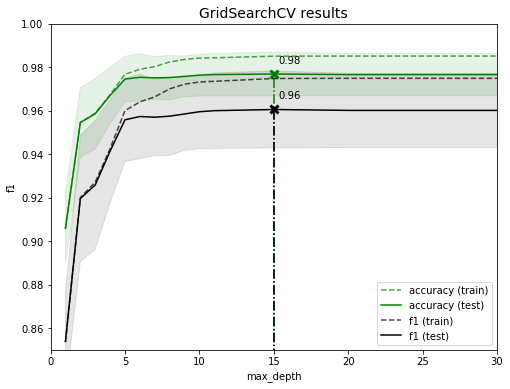

In [50]:
# https://scikit-learn.org/dev/auto_examples/model_selection/plot_multi_metric_evaluation.html
plt.figure(figsize=(8, 6))
plt.title("GridSearchCV results", fontsize=14)

plt.xlabel("max_depth")
plt.ylabel("f1")

ax = plt.gca()
ax.set_xlim(0, 30)
ax.set_ylim(0.85, 1)

X_axis = np.array(results['param_max_depth'].data, dtype=float)

for scorer, color in zip(sorted(scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index] + 0.3, best_score + 0.005))

plt.legend(loc="best")
plt.grid(False)
plt.savefig('GridSearchCV_results.png', dpi=300)
plt.show()

### Grid search

In [51]:
parameters = {'n_estimators': [50, 100], 
              'min_samples_leaf': [3, 5, 7],
              'max_features': [3, 5, 7, 10], 
              'max_depth': [17, 23]}

parameters = {'n_estimators': [100], 'max_features': [10]}

In [52]:
gcv = GridSearchCV(rfc, parameters, scoring=scoring, refit='f1', cv=10, return_train_score=True)
get_ipython().run_line_magic('time', 'gcv.fit(X, y)')

CPU times: user 11 s, sys: 55.7 ms, total: 11.1 s
Wall time: 11.1 s


GridSearchCV(cv=10, estimator=RandomForestClassifier(random_state=1),
             param_grid={'max_features': [10], 'n_estimators': [100]},
             refit='f1', return_train_score=True, scoring={'f1', 'accuracy'})

Let's take a look at the results of the parameter selection.

In [53]:
gcv.best_estimator_ 

RandomForestClassifier(max_features=10, random_state=1)

In [54]:
gcv.best_params_

{'max_features': 10, 'n_estimators': 100}

In [55]:
gcv.best_score_

0.9578133377376362

ОЦЕНКА ПО РЕАЛЬНЫМ ДАННЫМ

In [75]:
with open('webattack_detection_rf_model.pkl', 'rb') as f:
    rfc = pickle.load(f)
rfc

RandomForestClassifier(max_features=10, random_state=1)

In [76]:
df = pd.read_csv('mix_labelled.csv')
# df = pd.read_csv('mix_labelled.csv')
df['Label'] = df['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)
y_test = df['Label'].values
X_test = df[webattack_features]
print(X_test.shape, y_test.shape)

(1407, 10) (1407,)


In [77]:
import time
seconds = time.time()
y_pred = rfc.predict(X_test)
print("Total operation time:", time.time() - seconds, "seconds")

print("Benign records detected (0), attacks detected (1):")
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

Total operation time: 0.023569107055664062 seconds
Benign records detected (0), attacks detected (1):


{0: 1376, 1: 31}

In [78]:
import sklearn.metrics as metrics
accuracy = metrics.accuracy_score(y_test, y_pred)
f1 = metrics.f1_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred)
recall = metrics.recall_score(y_test, y_pred)
print('Precision =', precision)
print('Recall =', recall)
print('F1 =', f1)
print('Accuracy =', accuracy)

Precision = 1.0
Recall = 0.02203269367448472
F1 = 0.043115438108484005
Accuracy = 0.02203269367448472
